Since g2 data from measurements are saved in .spe files so we import an external library to read such files to get data in numpy arrays.

In [ ]:
# import libraries we need
%pylab inline
from implementations import sdt
import sys
sys.path.append('./sdt_reader/')
from tensorflow import keras

In [ ]:
# read data files
t1, y1 = sdt.read('./sdt_files/Antibunching_Rh110_DPC.sdt')
t2, y2 = sdt.read('./sdt_files/Antibunching_Rh110_Spc.sdt')

In [ ]:
# cut off the first and last few zero data points
y2 = y2[np.argwhere(y2>0)].flatten()
t2 = t2[np.argwhere(y2>0)].flatten()

We need to manually set the dip as the zero time delay. And also normalize the g2 signal to its maximum.

In [ ]:
# normalize g2 values and zero the time delay
t1_norm, y1_norm = sdt.normalize(t1,y1)
t2_norm, y2_norm = sdt.normalize(t2,y2)

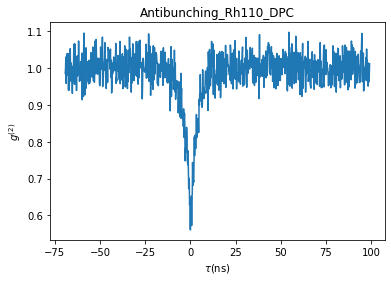

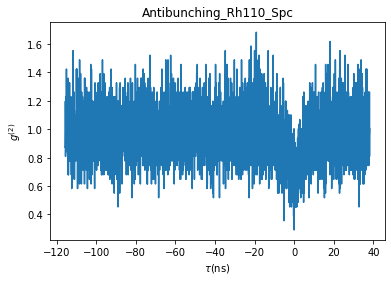

In [264]:
# take a look at the data
plt.figure(1)

plt.title('Antibunching_Rh110_DPC')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$') # un-normalized
plt.plot(t1_norm,y1_norm)

plt.figure(2)

plt.title('Antibunching_Rh110_Spc')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$')
plt.plot(t2_norm,y2_norm)
plt.show()


# MachineLearning Part

To avoid tensorflow occupying all CPUs or GPU in a computer we need to set processing units which tensorflow has access to use.

In [ ]:
# this is to limit the GPU and CPUs being occupied by tensorflow
from implementations import tf_setCPU

In [247]:
# create training sequences
time_step = 10
train1 = sdt.create_train(y1_norm,time_step)
#train2x, train2y = sdt.create_train(y1,time_step
train1 = train1.reshape(train1.shape[0],train1.shape[1],1)
train2 = sdt.create_train(y2_norm,time_step)
train2 = train2.reshape(train2.shape[0],train2.shape[1],1)

In [248]:
train1.shape

(1014, 10, 1)

Here I create a [1D CNN](https://keras.io/api/layers/convolution_layers/convolution1d/).

In [249]:
# create a training model
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape[1],train1.shape[2])))
model.add(keras.layers.Conv1D(filters=32, kernel_size=50, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1D(filters=16, kernel_size=50, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=50,activation="relu", padding="same"))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1DTranspose(filters=32, kernel_size=50,activation="relu", padding="same"))
model.add(keras.layers.Conv1DTranspose(filters=8, kernel_size=50, padding="same"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 10, 32)            1632      
_________________________________________________________________
dropout_42 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 10, 16)            25616     
_________________________________________________________________
conv1d_transpose_60 (Conv1DT (None, 10, 16)            12816     
_________________________________________________________________
dropout_43 (Dropout)         (None, 10, 16)            0         
_________________________________________________________________
conv1d_transpose_61 (Conv1DT (None, 10, 32)            25632     
_________________________________________________________________
conv1d_transpose_62 (Conv1DT (None, 10, 8)           

In [250]:
history = model.fit(train1,train1,epochs=20,validation_split=.1)

Epoch 1/20
29/29 [==============================] - 1s 7ms/step - loss: 0.7511 - val_loss: 0.0066
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0027
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 7/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 8/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 9/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 10/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 11/20
29/29 [

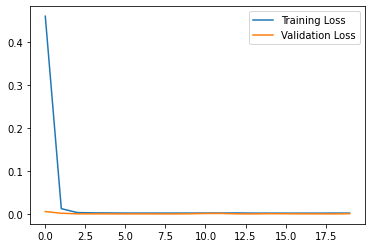

In [251]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [252]:
train2.shape

(3718, 10, 1)

In [260]:
# Get train MAE loss.
pred = model.predict(train2)


In [261]:
pred.shape

(3718, 10, 8)

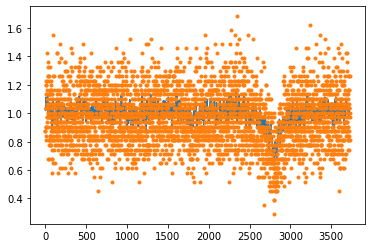

In [263]:
plt.plot(pred[:,2,5],label='normal')

plt.plot(y2_norm,'.',label='normal')


# Worked

In [ ]:
# create a training model
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape[1],train1.shape[2]),name='a'))
model.add(keras.layers.Conv1D(filters=32, kernel_size=50,input_shape=(train1.shape[0],train1.shape[1],1), padding="same", strides=1, activation="relu",name='b'))
model.add(keras.layers.Dropout(rate=0.2,name='c'))
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=50, padding="same",name='d'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()